In [26]:
import numpy as np
import cv2
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
figsize = (8,18)

def _plot(img):
    plt.figure(figsize=figsize)
    plt.imshow(img)

def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

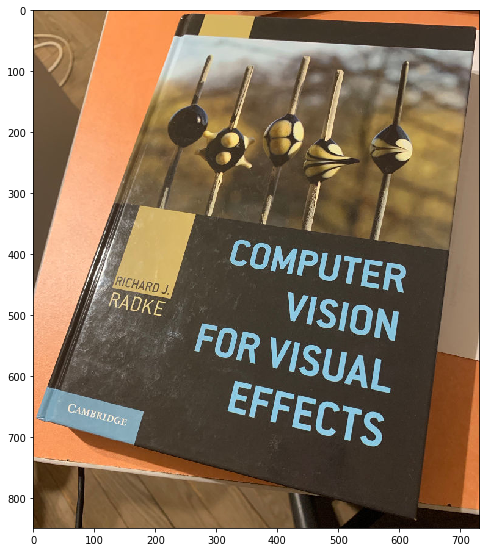

In [27]:
img_path = 'cvbook.jpg'
img = read_img(img_path)
_plot(img)

In [4]:
img.shape

(849, 732, 3)

In [28]:
original_points = np.float32([[241,6],[726,29],[6,668],[627,837]])

destination_size = (300, 400)
r,c = destination_size
transformed_points = np.float32([[0,0],[r,0],[0,c],[r,c]])

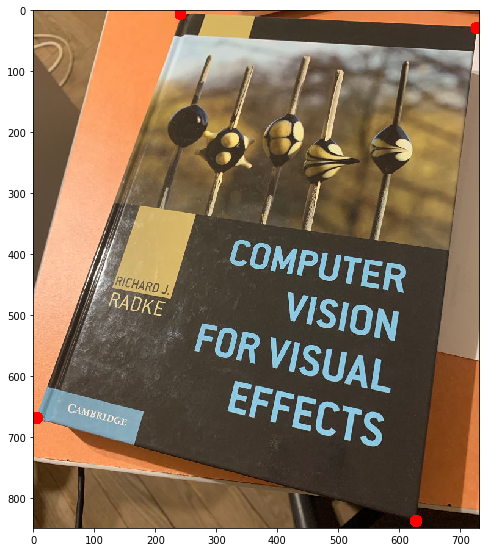

In [6]:
img_points = img.copy()
for p in original_points:
    cv2.circle(img_points, center=tuple(p), radius=10, color=(255,0,0), thickness=-1)

_plot(img_points)

In [29]:
def get_coef(a, b, n):
    res = []
    b = [b[0], b[1], 1]
    dim = 3
    for i in range(dim):
        curr = [0] * dim * 4
        curr[i] = a[0]
        curr[dim + i] = a[1]
        curr[2*dim + i] = 1 if i != 2 else 0
        
        curr[3*dim + n - 1] = -b[i]
        res.append(curr)
        
    return res

In [30]:
pts1, pts2 = original_points, transformed_points
A = []
plen = len(pts1)
for i in range(plen):
    A += get_coef(pts1[i], pts2[i], i)


In [31]:
def getPerspectiveTransform(pts1, pts2):
    A = []
    plen = len(pts1)
    for i in range(plen):
        A += get_coef(pts1[i], pts2[i], i)
        
    B = [0, 0, -1] * plen
    C = np.linalg.solve(A, B)
    # First 8 elements of C now contains a flattened transformation matrix M(the 9-th element is always set to 1)
    # while the last 4 elements are scaling factors specific for each example. Since we are only interested
    # in M, we will extract only its values below
    res = np.ones(9)
    res[:8] = C.flatten()[:8]
    print(res.reshape(3,-1))
    return res.reshape(3,-1).T
getPerspectiveTransform(original_points, transformed_points)

[[ 7.53496708e-01 -3.99227991e-02  3.03922821e-04]
 [ 2.67479949e-01  8.41850329e-01  6.21097907e-04]
 [-1.83197586e+02  4.57029261e+00  1.00000000e+00]]


array([[ 7.53496708e-01,  2.67479949e-01, -1.83197586e+02],
       [-3.99227991e-02,  8.41850329e-01,  4.57029261e+00],
       [ 3.03922821e-04,  6.21097907e-04,  1.00000000e+00]])

In [22]:
a = np.arange(18).reshape(2, 3, 3)
mtr = np.zeros((2, 3, 3), dtype='int')
print(a[:,0])
# for i in range(3):
#     mtr[:,i] = a[i]

[[ 0  1  2]
 [ 9 10 11]]


In [32]:
def to_mtx(img):
    H,V,C = img.shape
    mtr = np.zeros((V,H,C), dtype='int')
    for i in range(img.shape[0]):
        mtr[:,i] = img[i]
    
    return mtr

def to_img(mtr):
    V,H,C = mtr.shape
    img = np.zeros((H,V,C), dtype='int')
    for i in range(mtr.shape[0]):
        img[:,i] = mtr[i]
        
    return img

In [38]:
def warpPerspective(img, M, dsize):
    mtr = to_mtx(img)
    R,C = dsize
    dst = np.zeros((R,C,mtr.shape[2]))
    for i in range(mtr.shape[0]):
        for j in range(mtr.shape[1]):
            res = np.dot(M, [i,j,1])
            i2,j2,_ = (res / res[2] + 0.5).astype(int)
            if i2 >= 0 and i2 < R:
                if j2 >= 0 and j2 < C:
                    dst[i2,j2] = mtr[i,j]
    
    return to_img(dst)

In [93]:
M = np.arange(9).reshape(3, -1)
x = [1, 2, 1]
M.dot(x)

array([ 4, 16, 28])

In [36]:
%%time
M = getPerspectiveTransform(original_points, transformed_points)
print(M)

[[ 7.53496708e-01 -3.99227991e-02  3.03922821e-04]
 [ 2.67479949e-01  8.41850329e-01  6.21097907e-04]
 [-1.83197586e+02  4.57029261e+00  1.00000000e+00]]
[[ 7.53496708e-01  2.67479949e-01 -1.83197586e+02]
 [-3.99227991e-02  8.41850329e-01  4.57029261e+00]
 [ 3.03922821e-04  6.21097907e-04  1.00000000e+00]]
Wall time: 966 µs


Wall time: 6.35 s


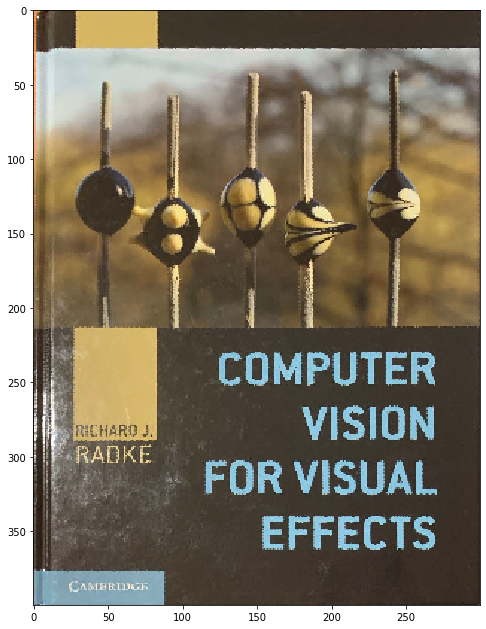

In [39]:
%%time
dst = warpPerspective(img, M, destination_size)
_plot(dst)